# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
!ls -al /input

total 8308
drwxr-xr-x   4 root root    6144 Apr 29 00:27 .
drwxr-xr-x 139 root root    4096 Aug 10 18:10 ..
drwxr-xr-x   2 root root 6137856 Apr 28 19:01 img_align_celeba
drwxr-xr-x   2 root root 2365440 Apr 28 18:57 mnist


In [31]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

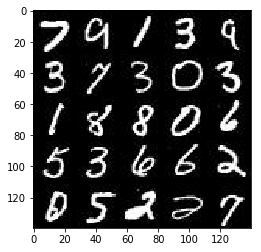

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

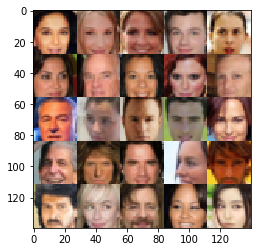

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [35]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_height, image_width, image_channels),
        name='real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return real_inputs, z_inputs, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False, alpha=0.2, kernel=6, filters=32):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input layer is 28x28x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters, kernel, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, filters*2, kernel, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(x2, filters*2, kernel, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 7*7*filters*2))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, kernel=6):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, kernel, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)






Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_height, image_width = data_shape[1], data_shape[2]
    real_inputs, z_inputs, lrate = model_inputs(
        image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = 2 * batch_images
                
                batch_z = np.random.uniform(-1 ,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_inputs: batch_images,
                    z_inputs: batch_z,
                    lrate: learning_rate
                })
                
                # Double the number of trains to generator
                _ = sess.run(g_opt, feed_dict={
                    z_inputs: batch_z,
                    real_inputs: batch_images,
                    lrate: learning_rate
                })
                
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(
                        sess,
                        25,
                        z_inputs,
                        image_channels,
                        data_image_mode
                    )
                  
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 0.6871 Sum Loss: 1.4344
Epoch 1/2... Discriminator Loss: 0.0884... Generator Loss: 2.9416 Sum Loss: 3.0300
Epoch 1/2... Discriminator Loss: 0.2231... Generator Loss: 1.8919 Sum Loss: 2.1151
Epoch 1/2... Discriminator Loss: 0.0404... Generator Loss: 3.6071 Sum Loss: 3.6475
Epoch 1/2... Discriminator Loss: 0.1803... Generator Loss: 4.2200 Sum Loss: 4.4003
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 1.7366 Sum Loss: 2.1491
Epoch 1/2... Discriminator Loss: 0.1530... Generator Loss: 2.5432 Sum Loss: 2.6962
Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 2.1370 Sum Loss: 2.4838
Epoch 1/2... Discriminator Loss: 0.3610... Generator Loss: 2.4467 Sum Loss: 2.8077
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.6214 Sum Loss: 1.9827


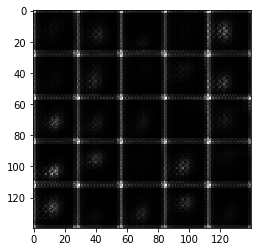

Epoch 1/2... Discriminator Loss: 1.7541... Generator Loss: 0.3790 Sum Loss: 2.1332
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.6126 Sum Loss: 1.6834
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 1.0137 Sum Loss: 2.0033
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.9169 Sum Loss: 2.3070
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 1.0321 Sum Loss: 2.4219
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.6720 Sum Loss: 1.9188
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 0.9970 Sum Loss: 1.9769
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.7580 Sum Loss: 1.9240
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7728 Sum Loss: 2.0478
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.9821 Sum Loss: 2.4121


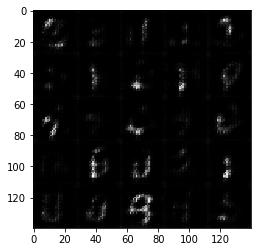

Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.6677 Sum Loss: 1.9784
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.7569 Sum Loss: 2.0187
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.7152 Sum Loss: 1.9912
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.7533 Sum Loss: 2.1342
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.7575 Sum Loss: 1.9906
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.6311 Sum Loss: 2.0628
Epoch 1/2... Discriminator Loss: 1.6217... Generator Loss: 0.5764 Sum Loss: 2.1981
Epoch 1/2... Discriminator Loss: 1.7173... Generator Loss: 0.4724 Sum Loss: 2.1897
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.9251 Sum Loss: 2.2332
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.7203 Sum Loss: 2.1366


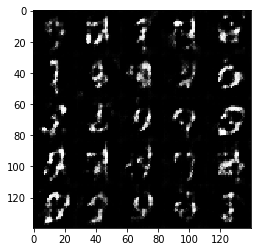

Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.6082 Sum Loss: 2.0740
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.6968 Sum Loss: 2.1547
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.6989 Sum Loss: 2.0406
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.7488 Sum Loss: 2.1083
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.7823 Sum Loss: 2.0215
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.8659 Sum Loss: 2.1103
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.5658 Sum Loss: 2.0231
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.7454 Sum Loss: 2.0953
Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 0.6676 Sum Loss: 2.1795
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.6255 Sum Loss: 2.0430


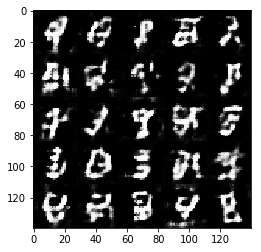

Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7019 Sum Loss: 2.0750
Epoch 1/2... Discriminator Loss: 1.7312... Generator Loss: 0.5585 Sum Loss: 2.2897
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.5712 Sum Loss: 2.0229
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.6855 Sum Loss: 1.9513
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.6782 Sum Loss: 2.0424
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.6979 Sum Loss: 2.1595
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.8167 Sum Loss: 1.9795
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.9763 Sum Loss: 2.3642
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.7092 Sum Loss: 2.0095
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.6721 Sum Loss: 2.0538


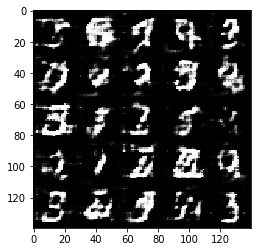

Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.7620 Sum Loss: 2.0155
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.7162 Sum Loss: 2.0483
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.6695 Sum Loss: 2.1157
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.8021 Sum Loss: 2.0698
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.7544 Sum Loss: 2.1057
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.6374 Sum Loss: 2.0259
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.6590 Sum Loss: 2.0954
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.7791 Sum Loss: 2.1645
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.7444 Sum Loss: 2.0994
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.7732 Sum Loss: 1.9652


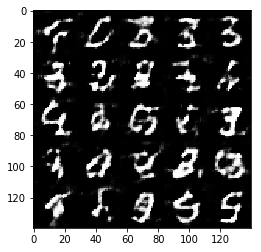

Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.8562 Sum Loss: 2.1092
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.7675 Sum Loss: 2.0550
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.7677 Sum Loss: 2.0664
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.6502 Sum Loss: 2.0970
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.7997 Sum Loss: 2.0361
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.7465 Sum Loss: 2.0592
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.8062 Sum Loss: 2.0875
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.8039 Sum Loss: 2.0732
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.7820 Sum Loss: 2.0428
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.7584 Sum Loss: 2.0824


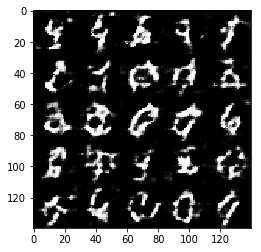

Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6682 Sum Loss: 2.0544
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.7517 Sum Loss: 2.0809
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.8258 Sum Loss: 1.9451
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.7168 Sum Loss: 2.0373
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.8048 Sum Loss: 2.1407
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.7599 Sum Loss: 2.1062
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7242 Sum Loss: 2.0775
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.9262 Sum Loss: 2.1839
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.7748 Sum Loss: 2.0596
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.6686 Sum Loss: 2.0358


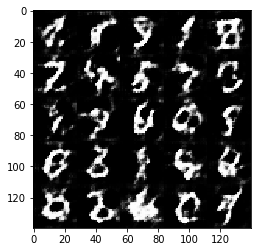

Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.8094 Sum Loss: 2.0738
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.6636 Sum Loss: 2.1234
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.7225 Sum Loss: 2.1184
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.7976 Sum Loss: 2.0758
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.8263 Sum Loss: 2.1222
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.7089 Sum Loss: 2.1205
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.6841 Sum Loss: 2.0083
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.7837 Sum Loss: 2.1324
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 0.7733 Sum Loss: 2.0122
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.7442 Sum Loss: 2.1080


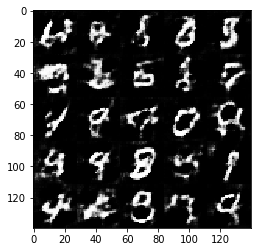

Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.6906 Sum Loss: 2.0468
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7314 Sum Loss: 1.9675
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.6097 Sum Loss: 2.0333
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.7024 Sum Loss: 2.0352
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.7101 Sum Loss: 2.0516
Epoch 2/2... Discriminator Loss: 1.2458... Generator Loss: 0.8305 Sum Loss: 2.0763
Epoch 2/2... Discriminator Loss: 1.2364... Generator Loss: 0.7795 Sum Loss: 2.0159
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.7970 Sum Loss: 2.0723
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.8143 Sum Loss: 2.1226
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.6786 Sum Loss: 2.0614


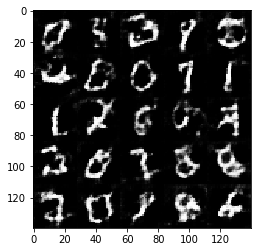

Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.7903 Sum Loss: 2.0873
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8110 Sum Loss: 2.1248
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.7057 Sum Loss: 2.0310
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.7724 Sum Loss: 2.0953
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.8228 Sum Loss: 2.0242
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6671 Sum Loss: 2.0534
Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.7080 Sum Loss: 1.9704
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.8490 Sum Loss: 2.1733
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.8925 Sum Loss: 2.0651
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.7635 Sum Loss: 2.1237


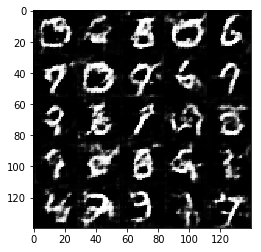

Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.8064 Sum Loss: 2.0649
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.7131 Sum Loss: 2.0540
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6656 Sum Loss: 2.0582
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.6922 Sum Loss: 2.0275
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.7345 Sum Loss: 2.0281
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.7162 Sum Loss: 2.0580
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.7502 Sum Loss: 2.1814
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 0.7463 Sum Loss: 2.1644
Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.7836 Sum Loss: 1.9641
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.6868 Sum Loss: 1.9908


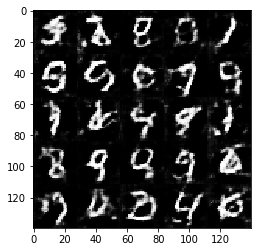

Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.7036 Sum Loss: 2.0772
Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.6706 Sum Loss: 1.9440
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.7527 Sum Loss: 2.1471
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.6988 Sum Loss: 2.0629
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7261 Sum Loss: 2.0598
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.7226 Sum Loss: 2.0496
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.7068 Sum Loss: 1.9318
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.6577 Sum Loss: 2.0384
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.7052 Sum Loss: 2.0205
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.7124 Sum Loss: 2.0154


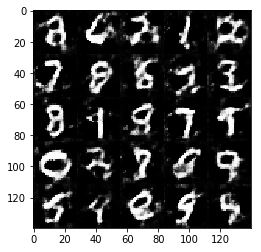

Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.7569 Sum Loss: 2.0356
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.7543 Sum Loss: 2.0643
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.7600 Sum Loss: 2.1170
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.6795 Sum Loss: 2.0234
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7959 Sum Loss: 2.1740
Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.7102 Sum Loss: 2.0052
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.7244 Sum Loss: 2.0999
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.7203 Sum Loss: 2.0509
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.7712 Sum Loss: 2.1482
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7046 Sum Loss: 2.0444


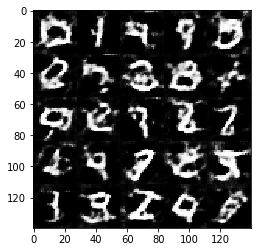

Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.7580 Sum Loss: 2.0475
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7762 Sum Loss: 2.1384
Epoch 2/2... Discriminator Loss: 1.4120... Generator Loss: 0.6615 Sum Loss: 2.0736
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.6980 Sum Loss: 2.0732
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.9564 Sum Loss: 2.3322
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.7166 Sum Loss: 1.9695
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.7906 Sum Loss: 2.1244
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.7129 Sum Loss: 2.0731
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.6497 Sum Loss: 2.1306
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.7668 Sum Loss: 2.1000


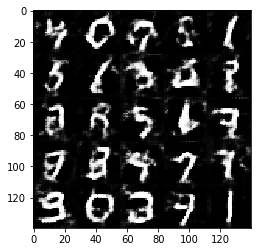

Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.6269 Sum Loss: 1.9981
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.8238 Sum Loss: 2.0722
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.7352 Sum Loss: 2.1263
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.7151 Sum Loss: 2.0435
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.6960 Sum Loss: 1.9441
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7718 Sum Loss: 2.0688
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.7863 Sum Loss: 2.1077
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.6803 Sum Loss: 2.0735
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.6976 Sum Loss: 2.0440
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.6734 Sum Loss: 2.0163


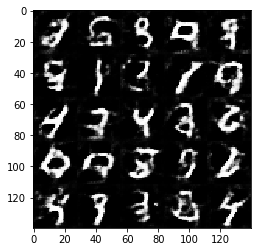

Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.7773 Sum Loss: 2.0802
Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 0.7659 Sum Loss: 2.1999
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7771 Sum Loss: 2.0381
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.6820 Sum Loss: 2.0499
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.6234 Sum Loss: 1.9540
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7095 Sum Loss: 2.0536
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.8773 Sum Loss: 2.1536
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.7254 Sum Loss: 2.0330
Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 0.7418 Sum Loss: 2.0257
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.8126 Sum Loss: 2.0646


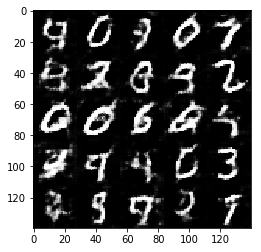

Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.7088 Sum Loss: 2.0573
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.6736 Sum Loss: 1.9790
Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.7592 Sum Loss: 2.0455
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.8336 Sum Loss: 2.1976
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.7333 Sum Loss: 2.1537
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.6912 Sum Loss: 2.1334
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.6669 Sum Loss: 1.9763
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.6798 Sum Loss: 2.0221
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.7909 Sum Loss: 2.0740
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.8079 Sum Loss: 2.1499


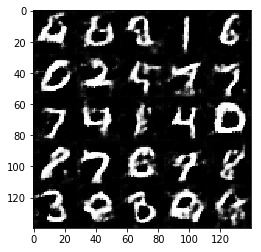

Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.7836 Sum Loss: 2.0649
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.7297 Sum Loss: 2.0906
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.6999 Sum Loss: 2.0278
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.7386 Sum Loss: 2.0257
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.7893 Sum Loss: 2.1531
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6721 Sum Loss: 2.0617
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.6770 Sum Loss: 2.0599


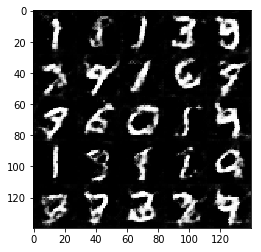

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1315... Generator Loss: 4.5446 Sum Loss: 4.6761
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 3.1196 Sum Loss: 3.1825
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 4.0365 Sum Loss: 4.0719
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 3.6852 Sum Loss: 3.7321
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 3.0346 Sum Loss: 3.1311
Epoch 1/1... Discriminator Loss: 0.1203... Generator Loss: 2.8000 Sum Loss: 2.9203
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 4.8298 Sum Loss: 5.5151
Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 2.8725 Sum Loss: 2.9983
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 5.2110 Sum Loss: 6.6128
Epoch 1/1... Discriminator Loss: 3.5971... Generator Loss: 0.1005 Sum Loss: 3.6976


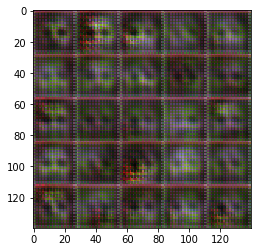

Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 2.7047 Sum Loss: 2.9103
Epoch 1/1... Discriminator Loss: 1.8788... Generator Loss: 0.3776 Sum Loss: 2.2564
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9438 Sum Loss: 1.9930
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.8785 Sum Loss: 1.8207
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 3.1033 Sum Loss: 4.3683
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.5629 Sum Loss: 2.0939
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.0696 Sum Loss: 1.7255
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 1.7553 Sum Loss: 2.2916
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 0.9290 Sum Loss: 1.7520
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.6124 Sum Loss: 2.5159


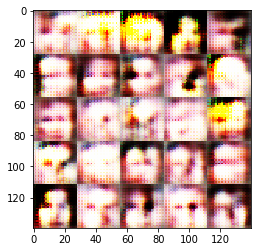

Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 0.9969 Sum Loss: 1.6961
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 2.3077 Sum Loss: 2.7254
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.9441 Sum Loss: 2.5303
Epoch 1/1... Discriminator Loss: 1.7089... Generator Loss: 0.3180 Sum Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.4741 Sum Loss: 2.0629
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 2.7292 Sum Loss: 3.7585
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.4867 Sum Loss: 2.3288
Epoch 1/1... Discriminator Loss: 0.2027... Generator Loss: 2.1317 Sum Loss: 2.3344
Epoch 1/1... Discriminator Loss: 1.7510... Generator Loss: 0.2870 Sum Loss: 2.0381
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 2.6087 Sum Loss: 3.5893


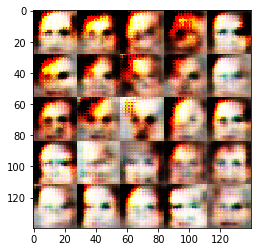

Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.3114 Sum Loss: 1.8277
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.6925 Sum Loss: 1.7076
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.2394 Sum Loss: 2.0399
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.3682 Sum Loss: 2.3506
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.4325 Sum Loss: 2.6685
Epoch 1/1... Discriminator Loss: 2.3632... Generator Loss: 1.9582 Sum Loss: 4.3214
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.6761 Sum Loss: 1.7992
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7530 Sum Loss: 1.9467
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7011 Sum Loss: 1.8190
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.4770 Sum Loss: 2.2194


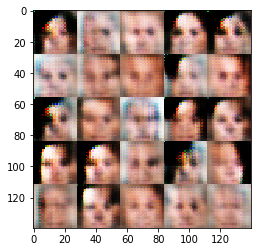

Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.8071 Sum Loss: 1.8001
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8817 Sum Loss: 2.1377
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.7256 Sum Loss: 1.7168
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 1.0326 Sum Loss: 2.4472
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.3435 Sum Loss: 2.3098
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9240 Sum Loss: 2.2021
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8673 Sum Loss: 2.1811
Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 0.4733 Sum Loss: 2.1424
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.2550 Sum Loss: 2.1338
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.5667 Sum Loss: 1.8909


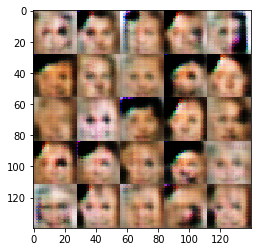

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.3415 Sum Loss: 1.8408
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7757 Sum Loss: 1.9582
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9439 Sum Loss: 2.0991
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.6710 Sum Loss: 1.8087
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6119 Sum Loss: 1.9863
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.3927 Sum Loss: 1.7566
Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.3722 Sum Loss: 2.0088
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.4585 Sum Loss: 2.6064
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.5522 Sum Loss: 1.9059
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1724 Sum Loss: 2.3493


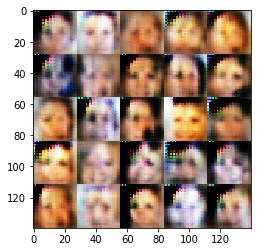

Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 0.7591 Sum Loss: 2.5078
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.7986 Sum Loss: 2.4931
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0582 Sum Loss: 2.1217
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8098 Sum Loss: 2.1784
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 1.1603 Sum Loss: 2.5618
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.8005 Sum Loss: 2.7750
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.3872 Sum Loss: 1.9019
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.8647 Sum Loss: 1.9276
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.9020 Sum Loss: 1.9245
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0476 Sum Loss: 2.2106


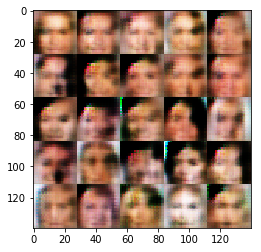

Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.1021 Sum Loss: 1.8968
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.9686 Sum Loss: 1.9634
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7104 Sum Loss: 1.8248
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7986 Sum Loss: 2.0310
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8699 Sum Loss: 2.2762
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.2977 Sum Loss: 1.8898
Epoch 1/1... Discriminator Loss: 1.7528... Generator Loss: 1.0547 Sum Loss: 2.8076
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7536 Sum Loss: 2.0156
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5447 Sum Loss: 1.9492
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 1.6210 Sum Loss: 3.0107


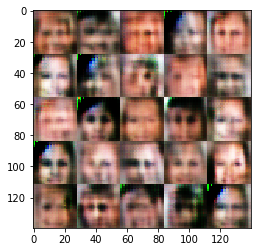

Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.0008 Sum Loss: 2.1716
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.5810 Sum Loss: 2.0753
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 2.1451 Sum Loss: 3.4860
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.9189 Sum Loss: 2.3535
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6694 Sum Loss: 1.9217
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.9223 Sum Loss: 2.2053
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6960 Sum Loss: 1.9280
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.5384 Sum Loss: 1.8147
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8620 Sum Loss: 2.1306
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.9666 Sum Loss: 2.1513


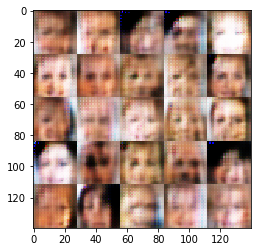

Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.4661 Sum Loss: 2.1171
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.9841 Sum Loss: 2.3512
Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 0.9300 Sum Loss: 2.5985
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.9414 Sum Loss: 2.2520
Epoch 1/1... Discriminator Loss: 1.8776... Generator Loss: 0.2403 Sum Loss: 2.1179
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.8027 Sum Loss: 2.1141
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.6839 Sum Loss: 1.9251
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.1137 Sum Loss: 2.4005
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9082 Sum Loss: 2.1899
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.9333 Sum Loss: 2.2440


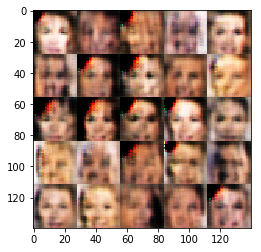

Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7236 Sum Loss: 2.1574
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.9895 Sum Loss: 2.4092
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8285 Sum Loss: 2.1257
Epoch 1/1... Discriminator Loss: 1.6462... Generator Loss: 0.3786 Sum Loss: 2.0248
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8545 Sum Loss: 1.9610
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 1.1216 Sum Loss: 2.2854
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.3247 Sum Loss: 1.9490
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.9466 Sum Loss: 2.1756
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.2091 Sum Loss: 2.3373
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6677 Sum Loss: 1.8692


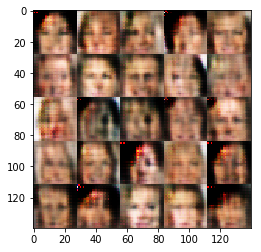

Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.3758 Sum Loss: 2.2373
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5498 Sum Loss: 2.0594
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.9241 Sum Loss: 2.4366
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7207 Sum Loss: 2.1577
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6494 Sum Loss: 2.1559
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8446 Sum Loss: 2.0143
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6127 Sum Loss: 1.9620
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7603 Sum Loss: 1.9274
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8593 Sum Loss: 1.9449
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6236 Sum Loss: 2.0690


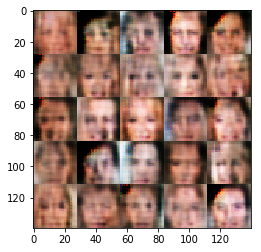

Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8466 Sum Loss: 2.2918
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.7795 Sum Loss: 1.7194
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.1703 Sum Loss: 2.2710
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7514 Sum Loss: 2.0191
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8938 Sum Loss: 2.3098
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8732 Sum Loss: 2.0301
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.6525 Sum Loss: 1.9764
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6897 Sum Loss: 2.0884
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.0369 Sum Loss: 2.2283
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.9632 Sum Loss: 2.3398


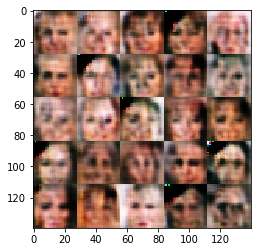

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9883 Sum Loss: 2.2333
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.7883 Sum Loss: 1.9316
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.7501 Sum Loss: 1.8114
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7435 Sum Loss: 2.1901
Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 0.3141 Sum Loss: 2.0242
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8931 Sum Loss: 2.1283
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 1.0368 Sum Loss: 2.3951
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7869 Sum Loss: 2.0315
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.5315 Sum Loss: 1.9270
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.6683 Sum Loss: 2.2467


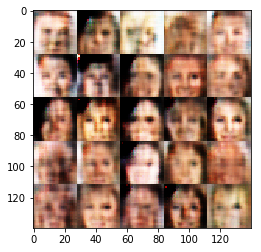

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.4860 Sum Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.0460 Sum Loss: 1.9479
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.3978 Sum Loss: 1.8401
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5245 Sum Loss: 1.9091
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.9015 Sum Loss: 2.4799
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9533 Sum Loss: 1.9786
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 1.0176 Sum Loss: 2.5499
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9571 Sum Loss: 2.2219
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9357 Sum Loss: 2.1682
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.7393 Sum Loss: 1.9385


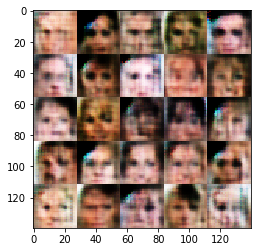

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8519 Sum Loss: 2.0588
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6152 Sum Loss: 2.0047
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.5870 Sum Loss: 2.9041
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 1.3917 Sum Loss: 2.9583
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 2.0907 Sum Loss: 2.9011
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7531 Sum Loss: 2.0955
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.5341 Sum Loss: 1.7690
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.9385 Sum Loss: 2.0484
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7121 Sum Loss: 1.9748
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.9164 Sum Loss: 2.0993


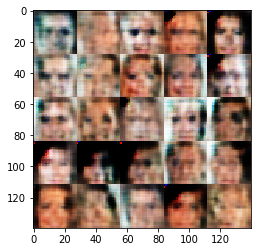

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.5511 Sum Loss: 1.8616
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.5167 Sum Loss: 1.8230
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.1650 Sum Loss: 2.1403
Epoch 1/1... Discriminator Loss: 1.8154... Generator Loss: 2.1915 Sum Loss: 4.0068
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8330 Sum Loss: 2.1321
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7020 Sum Loss: 2.0920
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8702 Sum Loss: 2.0421
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 1.1510 Sum Loss: 2.6989
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.5967 Sum Loss: 1.7806
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 1.4353 Sum Loss: 2.8926


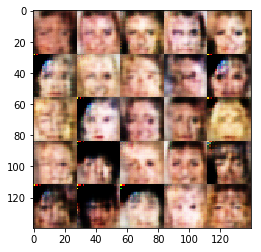

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 1.1150 Sum Loss: 2.5465
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 1.1816 Sum Loss: 2.7261
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8344 Sum Loss: 2.1395
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8227 Sum Loss: 2.0948
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9463 Sum Loss: 1.9592
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5801 Sum Loss: 1.8495
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.4318 Sum Loss: 2.0526
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.4710 Sum Loss: 1.8862
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.2692 Sum Loss: 2.1244
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.2533 Sum Loss: 2.1681


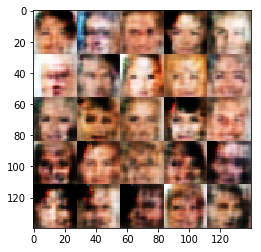

Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8921 Sum Loss: 1.9949
Epoch 1/1... Discriminator Loss: 1.8820... Generator Loss: 0.3259 Sum Loss: 2.2079
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 1.0083 Sum Loss: 2.4405
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8112 Sum Loss: 2.1142
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 1.0570 Sum Loss: 2.4259
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8574 Sum Loss: 2.1657
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.5797 Sum Loss: 2.0319
Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 0.9534 Sum Loss: 2.6110
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.7299 Sum Loss: 2.2682
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.0497 Sum Loss: 2.1979


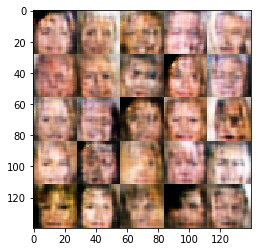

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7890 Sum Loss: 2.1253
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.8511 Sum Loss: 2.0974
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 2.2345 Sum Loss: 3.7118
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6072 Sum Loss: 1.9624
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.8479 Sum Loss: 2.4195
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.6405 Sum Loss: 2.2137
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.5940 Sum Loss: 2.0708
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8055 Sum Loss: 1.9355
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 1.4853 Sum Loss: 3.0790
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.3032 Sum Loss: 2.2747


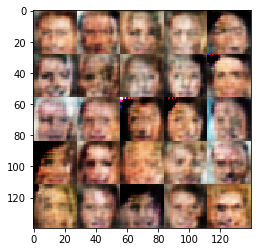

Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.5091 Sum Loss: 2.0490
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 0.7042 Sum Loss: 2.4235
Epoch 1/1... Discriminator Loss: 1.8480... Generator Loss: 0.4763 Sum Loss: 2.3242
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7305 Sum Loss: 2.1157
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6133 Sum Loss: 1.9988
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.8609 Sum Loss: 2.3747
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.8112 Sum Loss: 2.0457
Epoch 1/1... Discriminator Loss: 1.9648... Generator Loss: 1.1122 Sum Loss: 3.0770
Epoch 1/1... Discriminator Loss: 1.7165... Generator Loss: 0.7231 Sum Loss: 2.4396
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7581 Sum Loss: 1.9228


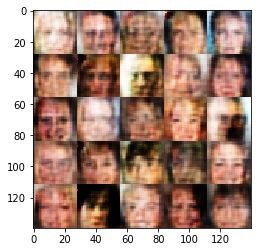

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6847 Sum Loss: 2.1349
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.9332 Sum Loss: 2.1839
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6870 Sum Loss: 2.0189
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.5226 Sum Loss: 1.8010
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6487 Sum Loss: 2.0894
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6334 Sum Loss: 2.0261
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.7615 Sum Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.9421 Sum Loss: 1.8520
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.5844 Sum Loss: 2.1861
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6182 Sum Loss: 1.9591


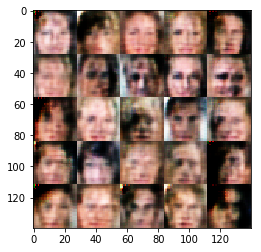

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.1757 Sum Loss: 2.4256
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8274 Sum Loss: 2.0950
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.0641 Sum Loss: 2.1738
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.8469 Sum Loss: 1.9721
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7683 Sum Loss: 1.9105
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7201 Sum Loss: 1.9780
Epoch 1/1... Discriminator Loss: 1.7202... Generator Loss: 1.3298 Sum Loss: 3.0499
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7296 Sum Loss: 2.1271
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8741 Sum Loss: 2.1337
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.4463 Sum Loss: 2.0557


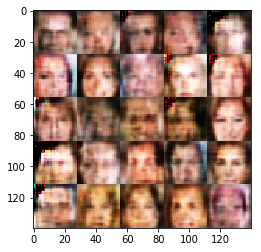

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.5004 Sum Loss: 1.8630
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.3348 Sum Loss: 2.1300
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 0.9849 Sum Loss: 1.7727
Epoch 1/1... Discriminator Loss: 2.2087... Generator Loss: 0.7706 Sum Loss: 2.9793
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 1.7035 Sum Loss: 3.2824
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5283 Sum Loss: 1.9019
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8539 Sum Loss: 2.2625
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7317 Sum Loss: 2.1097
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7065 Sum Loss: 1.9995
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.8138 Sum Loss: 1.8599


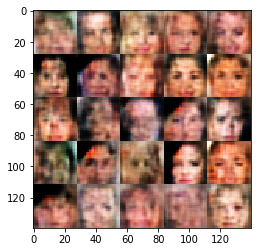

Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8639 Sum Loss: 2.0842
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5434 Sum Loss: 2.0445
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.6389 Sum Loss: 2.7861
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.2968 Sum Loss: 2.2208
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7521 Sum Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9725 Sum Loss: 2.2874
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.0526 Sum Loss: 2.2493
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.9013 Sum Loss: 2.0659
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6592 Sum Loss: 1.8467
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5695 Sum Loss: 1.7065


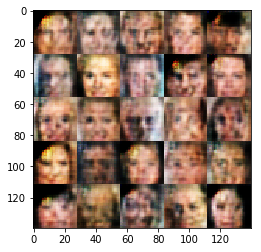

Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.3061 Sum Loss: 2.4530
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.8037 Sum Loss: 2.0398
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7772 Sum Loss: 2.0412
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.5916 Sum Loss: 2.1612
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0727 Sum Loss: 2.1778
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6208 Sum Loss: 1.9567
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6812 Sum Loss: 1.8553
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5898 Sum Loss: 2.0351
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7621 Sum Loss: 2.1183
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7998 Sum Loss: 2.0373


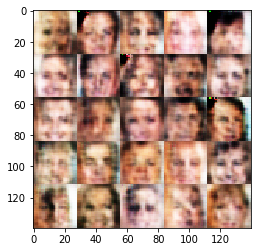

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5334 Sum Loss: 1.9040
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7607 Sum Loss: 2.1861
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7926 Sum Loss: 2.0398
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.5152 Sum Loss: 2.0563
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.6181 Sum Loss: 1.7946
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6956 Sum Loss: 2.1134
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6170 Sum Loss: 1.9292
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.5073 Sum Loss: 1.9581
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.6386 Sum Loss: 2.2291
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7953 Sum Loss: 2.0902


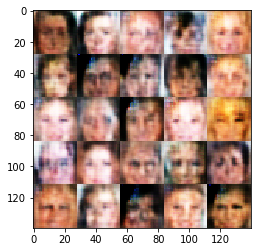

Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.6010 Sum Loss: 2.2217
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.4307 Sum Loss: 2.3571
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7321 Sum Loss: 1.8305
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7196 Sum Loss: 2.0031
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6984 Sum Loss: 2.1378
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.8449 Sum Loss: 1.6235
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8459 Sum Loss: 2.1371
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.7718 Sum Loss: 1.9959
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7342 Sum Loss: 1.9747
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.8223 Sum Loss: 2.2572


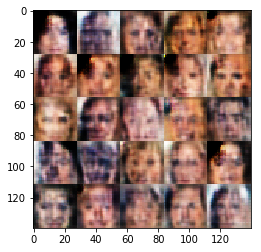

Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 0.9405 Sum Loss: 2.6505
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.5039 Sum Loss: 2.0059
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6885 Sum Loss: 1.9542
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6505 Sum Loss: 2.1179
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.5885 Sum Loss: 1.9556
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5854 Sum Loss: 2.0007
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7130 Sum Loss: 2.0195
Epoch 1/1... Discriminator Loss: 1.7127... Generator Loss: 0.5682 Sum Loss: 2.2809
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7905 Sum Loss: 2.0391
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7006 Sum Loss: 2.0944


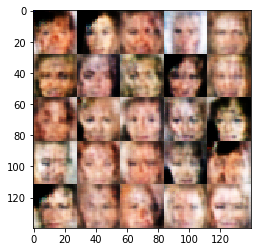

Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.8963 Sum Loss: 2.0397
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.9932 Sum Loss: 2.0935
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6920 Sum Loss: 2.0428
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8097 Sum Loss: 2.0099
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6463 Sum Loss: 2.0004
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6207 Sum Loss: 2.0502


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.